In [1]:
import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

# 加载模型和 tokenizer
def load_model_and_tokenizer(model_name, device="cuda"):
    print(f"Loading model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained("fla-hub/gla-1.3B-100B", use_fast=False)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map = {"": "cuda:0"},
        attn_implementation="eager",
    )
    return model, tokenizer

/home/fzkuji/anaconda3/envs/flash/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# model_path = "mistralai/Mistral-7B-Instruct-v0.1"
model_path = "Qwen/Qwen2-0.5B-Instruct"
# model_path = "mistralai/Mistral-7B-v0.1"
device = "cuda:0" if torch.cuda.is_available() else "mps"

# 加载模型和 tokenizer
model, tokenizer = load_model_and_tokenizer(model_path, device)

# model.config.sliding_window = 1024

Loading model: Qwen/Qwen2-0.5B-Instruct


In [5]:
# 加载和分词输入
max_length = 64
# dataset = load_dataset("emozilla/pg19", split="test", trust_remote_code=True)
# text = dataset[0]["text"]  # 仅取前 16384 个字符

In [49]:
text = " search search search search search search search search search search search search search search search search search search search search"

In [6]:
text = "The old lighthouse keeper had lived alone for thirty years, watching ships pass in the night. Every evening at sunset, he would climb the spiral stairs to light the beacon, his footsteps echoing in the empty tower. One stormy night, as waves crashed against the rocks below, he heard a peculiar sound - not the wind, not the sea, but music. Soft piano notes drifted up from somewhere below. He followed the melody down to a room he'd never noticed before, hidden behind a salt-stained door."

In [14]:
tokenized = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True)
input_ids = tokenized.input_ids
# 打印文本
# 打印text tokenizer后的ID与文本对
print(f"Text: {text}")
print(f"Tokenized IDs: {input_ids[0].tolist()}")
print(f"Tokenized Text: {tokenizer.decode(input_ids[0])}")



Text: The old lighthouse keeper had lived alone for thirty years, watching ships pass in the night. Every evening at sunset, he would climb the spiral stairs to light the beacon, his footsteps echoing in the empty tower.
Tokenized IDs: [1, 415, 1571, 305, 16190, 1284, 945, 7928, 553, 6262, 4411, 354, 9418, 1267, 28725, 6265, 11296, 1455, 297, 272, 2125, 28723, 4203, 6856, 438, 4376, 673, 28725, 400, 682, 17176, 272, 668, 10097, 12997, 298, 2061, 272, 347, 10364, 28725, 516, 3331, 16005, 3894, 288, 297, 272, 4606, 15894, 28723]
Tokenized Text: <s>The old lighthouse keeper had lived alone for thirty years, watching ships pass in the night. Every evening at sunset, he would climb the spiral stairs to light the beacon, his footsteps echoing in the empty tower.


In [15]:
input_ids = input_ids[:, 1:]

In [16]:
print(input_ids)

tensor([[  415,  1571,   305, 16190,  1284,   945,  7928,   553,  6262,  4411,
           354,  9418,  1267, 28725,  6265, 11296,  1455,   297,   272,  2125,
         28723,  4203,  6856,   438,  4376,   673, 28725,   400,   682, 17176,
           272,   668, 10097, 12997,   298,  2061,   272,   347, 10364, 28725,
           516,  3331, 16005,  3894,   288,   297,   272,  4606, 15894, 28723]])


In [17]:
# 提取注意力分数
# 模型前向
with torch.no_grad():
    output = model(input_ids.to(device), output_attentions=True, output_hidden_states=True)

In [18]:
print(output.keys())

odict_keys(['logits', 'past_key_values', 'hidden_states', 'attentions'])


In [19]:
print(len(output["attentions"]))

24


In [20]:
output["attentions"][0].shape

torch.Size([1, 14, 50, 50])

In [81]:
def visualize_attention_scores(
    attention_scores,
    layer_idx,
    head_idx,
    seq_len,
    output_file=None,
    norm_type="log",  # 标准化类型：可选 "log" 或 "minmax"
    cmap="plasma",    # 颜色映射：默认使用更高对比度的 plasma
    annotate=False    # 是否显示矩阵上的数值
):
    """
    可视化 Transformer 注意力分数矩阵。
    """
    plt.figure(figsize=(5, 4))
    attention_matrix = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()

    # 标准化注意力分数
    if norm_type == "log":
        epsilon = 1e-9
        attention_matrix = torch.log(attention_matrix + epsilon).numpy()
    elif norm_type == "minmax":
        attention_matrix = attention_matrix.numpy()
        attention_matrix = (attention_matrix - attention_matrix.min()) / (
            attention_matrix.max() - attention_matrix.min() + 1e-9
        )

    # 绘制矩阵
    im = plt.imshow(attention_matrix, cmap=cmap, aspect="auto")
    plt.colorbar(im, label="Normalized Attention Score")
    plt.title(f"Attention Layer {layer_idx + 1}, Head {head_idx + 1}")
    plt.xlabel("Key Position")
    plt.ylabel("Query Position")

    # 可选：添加数值标注
    if annotate:
        for i in range(seq_len):
            for j in range(seq_len):
                plt.text(j, i, f"{attention_matrix[i, j]:.2f}", ha="center", va="center", fontsize=6)

    # 保存图像或显示
    if output_file:
        plt.savefig(output_file, dpi=300)
    plt.show()


# # 可视化某一层的注意力分数
# def visualize_attention_scores(attention_scores, layer_idx, head_idx, seq_len, output_file=None):
#     plt.figure(figsize=(10, 8))
#     attention_matrix = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()
#     plt.imshow(attention_matrix, cmap="viridis", aspect="auto")
#     plt.colorbar(label="Attention Score")
#     plt.title(f"Attention Layer {layer_idx + 1}, Head {head_idx + 1}")
#     plt.xlabel("Key Position")
#     plt.ylabel("Query Position")
#     if output_file:
#         plt.savefig(output_file)
#     plt.show()


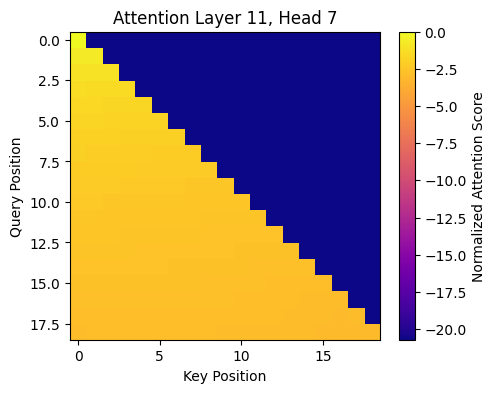

In [83]:

attention_scores = output["attentions"]

# 保存或可视化
layer_idx = 10  # 可视化第几层
head_idx = 6   # 可视化第几个注意力头
seq_len = 20  # 只显示前 1024 长度的分数（避免图太大）
visualize_attention_scores(attention_scores, layer_idx, head_idx, seq_len, output_file="attention_layer_1_head_1.png")

# # 保存完整注意力分数到文件
# torch.save(attention_scores, "attention_scores.pt")
# print("Attention scores saved to 'attention_scores.pt'")

In [84]:
# 可视化最后一个token的注意力分数，画出折线图

def visualize_last_token_attention_scores(
    attention_scores,
    layer_idx,
    head_idx,
    seq_len,
    output_file=None,
    norm_type="log",  # 标准化类型：可选 "log" 或 "minmax"
    cmap="plasma",    # 颜色映射：默认使用更高对比度的 plasma
):
    """
    可视化 Transformer 最后一个 token 的注意力分数。
    """
    plt.figure(figsize=(5, 4))
    attention_matrix = attention_scores[layer_idx][0, head_idx, -1, :seq_len].cpu()

    # 标准化注意力分数
    if norm_type == "log":
        epsilon = 1e-9
        attention_matrix = torch.log(attention_matrix + epsilon).numpy()
    elif norm_type == "minmax":
        attention_matrix = attention_matrix.numpy()
        attention_matrix = (attention_matrix - attention_matrix.min()) / (
            attention_matrix.max() - attention_matrix.min() + 1e-9
        )

    # 绘制折线图
    plt.plot(attention_matrix, marker='o', color='blue')
    plt.title(f"Last Token Attention Layer {layer_idx + 1}, Head {head_idx + 1}")
    plt.xlabel("Key Position")
    plt.ylabel("Attention Score")

    # 保存图像或显示
    if output_file:
        plt.savefig(output_file, dpi=300)
    plt.show()

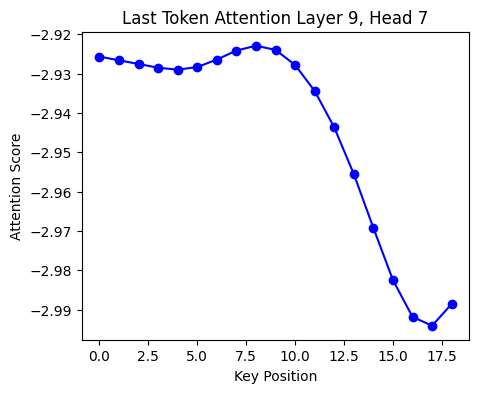

In [94]:
# 可视化最后一个 token 的注意力分数
layer_idx = 8  # 可视化第几层
head_idx = 6   # 可视化第几个注意力头
seq_len = 20  # 只显示前 1024 长度的分数（避免图太大）

visualize_last_token_attention_scores(
    attention_scores, layer_idx, head_idx, seq_len, output_file="last_token_attention_layer_1_head_1.png"
)

In [95]:
# 画最后一个token所有头的的注意力折线图 一张图画多个
def visualize_last_token_all_heads_attention_scores(
    attention_scores,
    layer_idx,
    seq_len,
    output_file=None,
    norm_type="log",  # 标准化类型：可选 "log" 或 "minmax"
    cmap="plasma",    # 颜色映射：默认使用更高对比度的 plasma
):
    """
    可视化 Transformer 最后一个 token 的所有头的注意力分数。
    """
    plt.figure(figsize=(10, 6))

    for head_idx in range(attention_scores[layer_idx].shape[1]):
        attention_matrix = attention_scores[layer_idx][0, head_idx, -1, :seq_len].cpu()

        # 标准化注意力分数
        if norm_type == "log":
            epsilon = 1e-9
            attention_matrix = torch.log(attention_matrix + epsilon).numpy()
        elif norm_type == "minmax":
            attention_matrix = attention_matrix.numpy()
            attention_matrix = (attention_matrix - attention_matrix.min()) / (
                attention_matrix.max() - attention_matrix.min() + 1e-9
            )

        # 绘制折线图
        plt.plot(attention_matrix, marker='o', label=f'Head {head_idx + 1}')

    plt.title(f"Last Token Attention Layer {layer_idx + 1} - All Heads")
    plt.xlabel("Key Position")
    plt.ylabel("Attention Score")
    plt.legend()

    # 保存图像或显示
    if output_file:
        plt.savefig(output_file, dpi=300)
    plt.show()

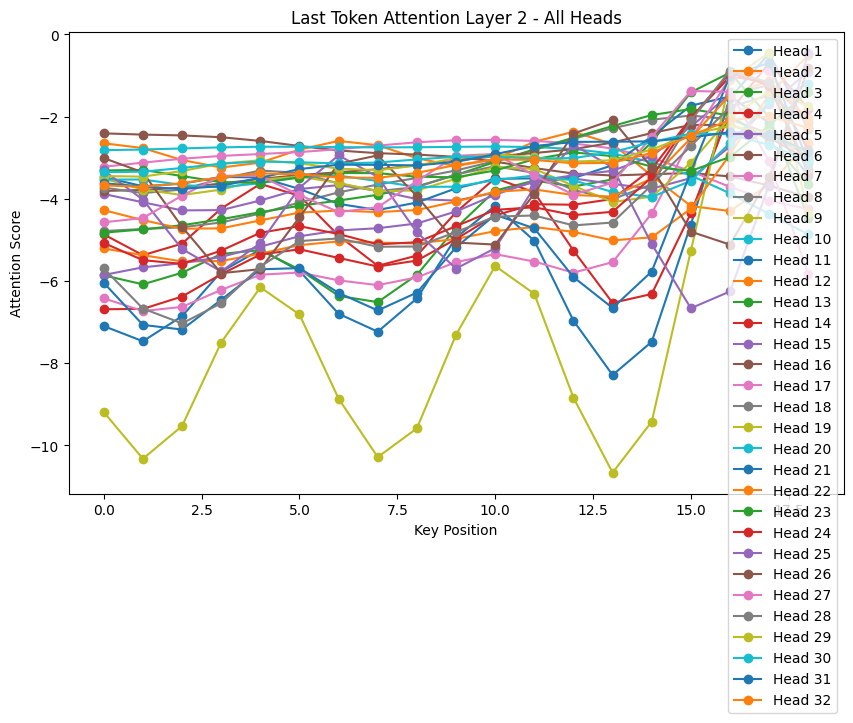

In [96]:
# 可视化最后一个 token 的所有头的注意力分数
layer_idx = 1  # 可视化第几层
seq_len = 20  # 只显示前 1024 长度的分数（避免图太大）
visualize_last_token_all_heads_attention_scores(
    attention_scores, layer_idx, seq_len, output_file="last_token_attention_all_heads_layer_1.png"
)

In [60]:
################################swt###############################
def visualize_all_head_avg_attention_scores(
    attention_scores,
    layer_idx,
    seq_len,
    output_file=None,
    norm_type="log",  # 标准化类型：可选 "log" 或 "minmax"
    cmap="plasma",    # 颜色映射：默认使用更高对比度的 plasma
    annotate=False    # 是否显示矩阵上的数值
):
    """
    可视化 Transformer 注意力分数矩阵。
    """
    plt.figure(figsize=(5, 4))
    # attention_matrix = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()
    
    attention_tensor = attention_scores[layer_idx][0]  # shape: (num_heads, seq_len, seq_len)
    mean_attention = attention_tensor.mean(dim=0).cpu()  # shape: (seq_len, seq_len)

    # 标准化注意力分数
    if norm_type == "log":
        epsilon = 1e-9
        mean_attention = torch.log(mean_attention + epsilon).numpy()
    elif norm_type == "minmax":
        mean_attention = mean_attention.numpy()
        mean_attention = (mean_attention - mean_attention.min()) / (
            mean_attention.max() - mean_attention.min() + 1e-9
        )

    # 绘制矩阵
    im = plt.imshow(mean_attention, cmap=cmap, aspect="auto")
    plt.colorbar(im, label="Normalized Attention Score")
    plt.title(f"Attention Layer {layer_idx + 1}")
    plt.xlabel("Key Position")
    plt.ylabel("Query Position")

    # 可选：添加数值标注
    if annotate:
        for i in range(seq_len):
            for j in range(seq_len):
                plt.text(j, i, f"{mean_attention[i, j]:.2f}", ha="center", va="center", fontsize=6)

    # 保存图像或显示
    if output_file:
        plt.savefig(output_file, dpi=300)
    plt.show()


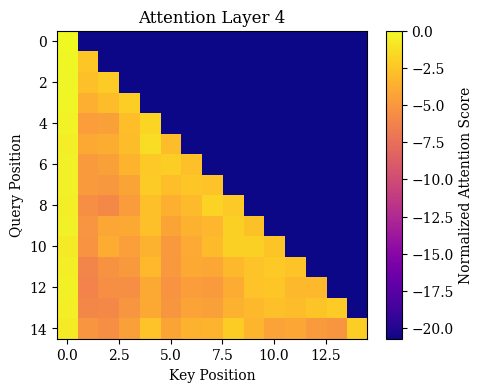

In [71]:
################################swt###############################
attention_scores = output["attentions"]

# 保存或可视化
layer_idx = 3  # 可视化第几层
seq_len = 8192  # 只显示前 1024 长度的分数（避免图太大）
visualize_all_head_avg_attention_scores(attention_scores, layer_idx, seq_len, output_file="attention_layer_1_head_1.png")

# # 保存完整注意力分数到文件
# torch.save(attention_scores, "attention_scores.pt")
# print("Attention scores saved to 'attention_scores.pt'")

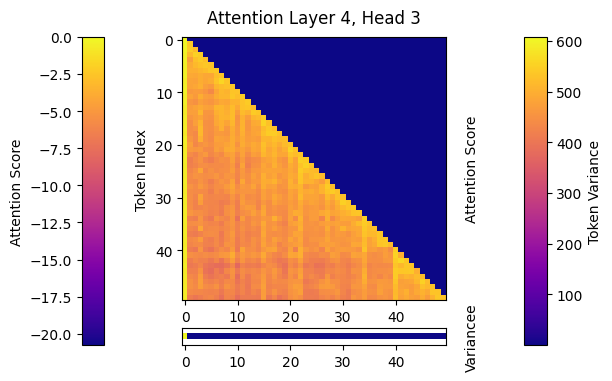

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_attention_and_variance(
    attention_scores,
    hidden_states,
    layer_idx,
    head_idx,
    seq_len,
    output_file=None,
    norm_type="log",  # 标准化类型：可选 "log" 或 "minmax"
    cmap="plasma",    # 颜色映射：默认使用更高对比度的 plasma
    annotate=False    # 是否显示矩阵上的数值
):
    """
    将布局改为：
    ┌─────────┬─────────────────┬─────────┐
    │         │   上:热力图     │         │
    │  左CB   ├─────────────────┤  右CB   │
    │         │   下:热力图     │         │
    └─────────┴─────────────────┴─────────┘
    其中 1×3 网格：左列放注意力热力图的colorbar，中间列是上下热力图(再细分为2×1)，右列放方差热力图的colorbar
    """

    # 1. 创建主图与 1×3 主网格
    fig = plt.figure(figsize=(6, 4))
    gs_main = fig.add_gridspec(nrows=1, ncols=3, width_ratios=[0.2, 3, 0.2], wspace=0.3)

    # 2. 中间列做成 2 行 1 列的子网格，用于放置上下两个热力图
    gs_center = gs_main[0, 1].subgridspec(nrows=2, ncols=1, height_ratios=[16, 1], hspace=0.2)

    # 分别创建上、下两个 Axes
    ax_top = fig.add_subplot(gs_center[0, 0])    # 上
    ax_bottom = fig.add_subplot(gs_center[1, 0]) # 下

    # 左侧 colorbar Axes (给“上方注意力”用)
    cax_left = fig.add_subplot(gs_main[0, 0])
    # 右侧 colorbar Axes (给“下方方差”用)
    cax_right = fig.add_subplot(gs_main[0, 2])

    # 3. 处理注意力矩阵
    attention_tensor = attention_scores[layer_idx][0]  # shape: (num_heads, seq_len, seq_len)
    attention_matrix = attention_tensor.mean(dim=0).cpu()  # shape: (seq_len, seq_len)
    # attention_matrix = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()
    if norm_type == "log":
        epsilon = 1e-9
        attention_matrix = torch.log(attention_matrix + epsilon).float().numpy()
    elif norm_type == "minmax":
        attention_matrix = attention_matrix.numpy()
        attention_matrix = (attention_matrix - attention_matrix.min()) / (
            attention_matrix.max() - attention_matrix.min() + 1e-9
        )
    else:
        attention_matrix = attention_matrix.numpy()

    # 4. 绘制“上方”的注意力热力图
    im1 = ax_top.imshow(attention_matrix, cmap=cmap, aspect="equal", interpolation="nearest")
    ax_top.set_box_aspect(1)
    ax_top.set_title(f"Attention Layer {layer_idx + 1}, Head {head_idx + 1}", pad=10)
    ax_top.set_xlabel("Token Index")
    ax_top.set_ylabel("Token Index")
    # 在右边添加额外的标签
    ax_top.text(1.1, 0.5, "Attention Score", transform=ax_top.transAxes, rotation=90, va="center", ha="center")

    # 可选：矩阵数值标注
    if annotate:
        for i in range(seq_len):
            for j in range(seq_len):
                ax_top.text(j, i, f"{attention_matrix[i, j]:.2f}",
                            ha="center", va="center", fontsize=6)

    # 给“上方热力图”创建 colorbar，放在左侧 cax_left
    cb1 = fig.colorbar(im1, cax=cax_left, orientation='vertical')
    cb1.set_label("Attention Score")
    cb1.ax.yaxis.set_ticks_position('left')
    cb1.ax.yaxis.set_label_position('left')

    # 5. 计算并绘制“下方”的方差热力图（单行）
    token_variances = torch.var(hidden_states[layer_idx][:, :seq_len, :], dim=-1).squeeze(0).cpu().float().numpy()
    token_variances = np.expand_dims(token_variances, axis=0)  # 转为 1×N

    im2 = ax_bottom.imshow(token_variances, cmap=cmap, aspect="equal", interpolation="nearest")
    # ax_bottom.set_title(f"Token Variance for Layer {layer_idx + 1}", y=-1.5)
    # ax_bottom.set_ylabel("Variance", y=0.5, x=1.05)
    ax_bottom.text(1.1, 0.5, "Variancee", transform=ax_bottom.transAxes, rotation=90, va="center", ha="center")
    ax_bottom.yaxis.set_label_position('right')
    ax_bottom.set_box_aspect(1/16)
    ax_bottom.set_yticks([])  # 隐藏 y 轴

    # 给“下方热力图”创建 colorbar，放在右侧 cax_right
    cb2 = fig.colorbar(im2, cax=cax_right, orientation='vertical')
    cb2.set_label("Token Variance")

    # 6. 保存或者显示
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()

visualize_attention_and_variance(output["attentions"], output["hidden_states"], layer_idx=3, head_idx=2, seq_len=50)

In [72]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.ticker as mticker
# 设置全局字体
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "DejaVu Serif"

def visualize_multi_layers_single_row(
    attention_scores,
    hidden_states,
    layers,              # list/iterable of layer indices to plot
    head_idx,            # 如果你只想看同一个 head，可固定 head_idx
    seq_len,
    output_file=None,
    norm_type="log",     # "log", "minmax", 或 None
    cmap="plasma",
    annotate=False
):
    """
    在“只有一行”的布局下，横向排多个 Layer，每个 Layer 里再上下叠放:
      - 上: 注意力 (seq_len×seq_len)
      - 下: 方差   (1×seq_len)
    左右两侧各只放一个 colorbar：左边给所有注意力图，右边给所有方差图。

    最外层 1×(num_layers + 2) 网格结构:
    ┌──────────┬────────────────┬────────────────┬ ... ┬─────────────────┬───────────┐
    │ 左CB(col=0) │ Layer1(subgrid) │ Layer2(subgrid) │ ... │ LayerN(subgrid) │ 右CB(col=N+1)│
    └──────────┴────────────────┴────────────────┴-----┴─────────────────┴───────────┘

    其中每个 layer 的 subgrid 再是 2×1:
      - row=0: 注意力热力图(上)
      - row=1: 方差热力图(下)
    """

    num_layers = len(layers)

    #========== 1. 预先收集所有矩阵、计算全局 min/max ==========#
    all_attention_mats = []
    all_variance_mats  = []
    for layer_idx in layers:
        # ---- 注意力矩阵 ----
        # attn_mat = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()
        attn_tensor = attention_scores[layer_idx][0, :, :seq_len, :seq_len].cpu()  # (n_heads, seq, seq)
        attn_mat = attn_tensor.mean(dim=0)                                         # (seq, seq)

        if norm_type == "log":
            epsilon = 1e-9
            attn_mat = torch.log(attn_mat + epsilon)
        elif norm_type == "minmax":
            attn_mat = (attn_mat - attn_mat.min()) / (attn_mat.max() - attn_mat.min() + 1e-9)
        attn_mat = attn_mat.numpy()
        all_attention_mats.append(attn_mat)

        # ---- 方差矩阵(1×seq_len) ----
        var_mat = torch.var(hidden_states[layer_idx][:, :seq_len, :], dim=-1).squeeze(0).cpu().numpy()
        var_mat = np.expand_dims(var_mat, axis=0)  # 变成 (1, seq_len)
        all_variance_mats.append(var_mat)

    # (可选) 全局 min/max, 用于共享色表
    attn_min = min(m.min() for m in all_attention_mats)
    attn_max = max(m.max() for m in all_attention_mats)
    var_min  = min(m.min() for m in all_variance_mats)
    # var_max  = max(m.max() for m in all_variance_mats)
    var_max = 500

    attn_norm = mpl.colors.Normalize(vmin=attn_min, vmax=attn_max)
    var_norm  = mpl.colors.Normalize(vmin=var_min, vmax=var_max)

    #========== 2. 创建最外层 figure & gridspec (1 行 + num_layers+2 列) ==========#
    fig = plt.figure(figsize=(3.5 + 3.2*num_layers, 4))
    gs_main = fig.add_gridspec(
        nrows=1, ncols=num_layers+2,
        width_ratios=[1] + [4]*num_layers + [1],  # 左 colorbar(0.2), 中间每层(3), 右 colorbar(0.2)
        wspace=0.0
    )

    # 左、右 colorbar Axes
    cax_left  = fig.add_subplot(gs_main[0, 0])
    cax_right = fig.add_subplot(gs_main[0, num_layers+1])

    #========== 3. 遍历每个 layer，在中间相应的列创建 2×1 subgridspec ==========#
    for i, layer_idx in enumerate(layers):
        # 这个列在 top-level gridspec 中是 col = i + 1
        subgrid = gs_main[0, i+1].subgridspec(nrows=3, ncols=1, height_ratios=[16, 0.0, 1], hspace=0.4)

        # -- 上: 注意力热力图 --
        ax_top = fig.add_subplot(subgrid[0, 0])
        attn_mat = all_attention_mats[i]
        im_top = ax_top.imshow(
            attn_mat,
            cmap=cmap,
            norm=attn_norm,
            aspect="equal",
            interpolation="nearest"
        )
        # 标题
        ax_top.set_title(f"Layer {layer_idx+1}", pad=10, fontsize=18)

        ax_top.set_xlabel("Token Index", fontsize=14)
        # 如果是第一个 layer，添加 x 轴标签
        if i == 0:
            ax_top.set_ylabel("Token Index", fontsize=14)
        # 保证上图是 NxN 正方形
        ax_top.set_box_aspect(1)

        # 是否在热力图内显示数值
        if annotate:
            s_len = attn_mat.shape[0]
            for r in range(s_len):
                for c in range(s_len):
                    ax_top.text(c, r, f"{attn_mat[r,c]:.2f}",
                                ha="center", va="center", fontsize=6)

        # 设置刻度标签大小
        ax_top.tick_params(labelsize=14)

        # -- 下: 方差热力图(1×seq_len) --
        ax_bottom = fig.add_subplot(subgrid[2, 0])
        var_mat = all_variance_mats[i]
        im_bottom = ax_bottom.imshow(
            var_mat,
            cmap=cmap,
            norm=var_norm,
            aspect="equal",
            interpolation="nearest"
        )
        ax_bottom.set_xlabel("Token Variance", fontsize=18, labelpad=10)
        ax_bottom.tick_params(axis='x', which='both', labelbottom=False)
        ax_bottom.xaxis.tick_top()
        ax_bottom.set_yticks([])  # 隐藏 y 轴
        # 下图只有 1 行 vs. seq_len 列，如果想让每个格子跟上面一样大，需要适度控制纵横比
        # 这里 height_ratios=[16,1] 已经让下方更扁，同时 aspect="equal" 让其看起来为小方格
        # 也可再对 set_box_aspect() 做精调:
        #   ax_bottom.set_box_aspect(1/16)  # 视 seq_len 的大小而定
        # ax_bottom.set_box_aspect(1/16)

        # 如果是最后一个 layer，添加右侧 text
        if i == num_layers - 1:
            ax_top.text(1.14, 0.5, "Attention Score", transform=ax_top.transAxes, rotation=90, va="center", ha="center", fontsize=18)
            # ax_bottom.text(1.1, 0.5, "Variance", transform=ax_bottom.transAxes, rotation=90, va="center", ha="center", fontsize=14)

    #========== 4. 整体只放两个 colorbar：左(注意力)、右(方差) ==========#
    # 注意力 colorbar
    sm_attn = mpl.cm.ScalarMappable(norm=attn_norm, cmap=cmap)
    cb1 = fig.colorbar(sm_attn, cax=cax_left, orientation='vertical')
    cb1.ax.yaxis.set_ticks_position('left')
    cb1.ax.yaxis.set_label_position('left')
    cb1.set_label("Attention Score", fontsize=18, labelpad=5)
    # 设置刻度标签大小
    cb1.ax.tick_params(labelsize=16)

    # 方差 colorbar
    sm_var = mpl.cm.ScalarMappable(norm=var_norm, cmap=cmap)
    cb2 = fig.colorbar(sm_var, cax=cax_right, orientation='vertical')
    cb2.set_label("Token Variance", fontsize=18, labelpad=10)
    # 设置刻度标签大小
    cb2.ax.tick_params(labelsize=16)

    # ---------- 在这里插入“空白” ----------
    def add_axes_padding(ax,
                         pad_left=0.0, pad_right=0.0,
                         pad_top=0.0, pad_bottom=0.0):
        """
        给指定的 ax 在四个方向上各留一定比例的空白：
          pad_left   : 左边留原宽度 pad_left 倍的空白，并向右移同样的距离
          pad_right  : 右边留原宽度 pad_right 倍的空白，并缩小宽度
          pad_bottom : 底部留原高度 pad_bottom 倍的空白，并向上移同样的距离
          pad_top    : 顶部留原高度 pad_top 倍的空白，并缩小高度

        参数均为相对比例，例如 pad_left=0.1 意味着「左边留出原宽度的 10%」。
        """
        x0, y0, w, h = ax.get_position().bounds

        new_x0 = x0 + pad_left * w
        new_width = w * (1 - pad_left - pad_right)
        new_y0 = y0 + pad_bottom * h
        new_height = h * (1 - pad_top    - pad_bottom)

        ax.set_position([new_x0, new_y0, new_width, new_height])

    # 例如上下各留 5%:
    # 画完 colorbars 之后
    # 左右各留 5%，上下各留 10% 的空间
    add_axes_padding(cax_left,  pad_left=0.0, pad_right=0.8,
                                 pad_top=0.10,  pad_bottom=0.10)
    add_axes_padding(cax_right, pad_left=0.8, pad_right=0.0,
                                 pad_top=0.10,  pad_bottom=0.10)

    #========== 5. 保存或显示 ==========#
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()

layers_to_plot = [2, 3, 4, 5]
visualize_multi_layers_single_row(
    attention_scores=output["attentions"],
    hidden_states=output["hidden_states"],
    layers=layers_to_plot,
    head_idx=2,
    seq_len=50,
    norm_type="minmax",    # 可选: "log", "minmax", 或 None
    cmap="plasma",
    annotate=False,
    output_file="Figure 3.pdf"
)


TypeError: Got unsupported ScalarType BFloat16

-20.75


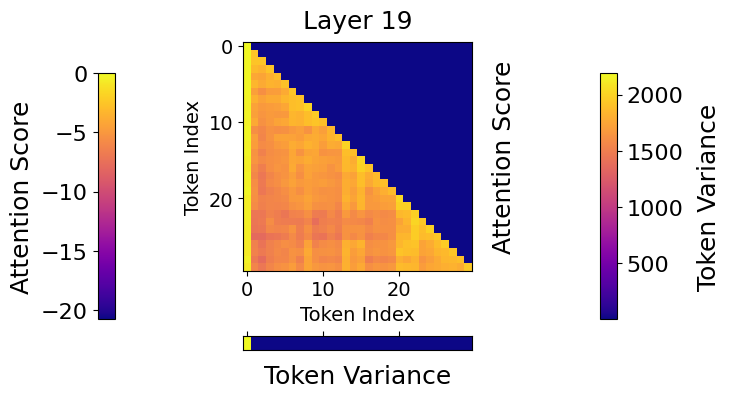

In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.ticker as mticker

from matplotlib import font_manager as fm

# # 加载字体文件
# # 1. 加载本地字体文件
# font_path = "./times.ttf"
# my_font_prop = fm.FontProperties(fname=font_path)
#
# # 2. 手动添加这个字体到 matplotlib 的字体列表（确保优先使用它）
# fm.fontManager.addfont(font_path)
#
# # 3. 设置全局字体为该字体的名称（保证用的是你加载的本地字体）
# plt.rcParams["font.family"] = my_font_prop.get_name()
# # plt.rcParams["font.family"] = "Times New Roman"
# # plt.rcParams["font.family"] = "DejaVu Serif"

def visualize_multi_layers_single_row(
    attention_scores,
    hidden_states,
    layers,              # list/iterable of layer indices to plot
    head_idx,            # 如果你只想看同一个 head，可固定 head_idx
    seq_len,
    output_file=None,
    norm_type="log",     # "log", "minmax", 或 None
    cmap="plasma",
    annotate=False
):
    """
    在“只有一行”的布局下，横向排多个 Layer，每个 Layer 里再上下叠放:
      - 上: 注意力 (seq_len×seq_len)
      - 下: 方差   (1×seq_len)
    左右两侧各只放一个 colorbar：左边给所有注意力图，右边给所有方差图。

    最外层 1×(num_layers + 2) 网格结构:
    ┌──────────┬────────────────┬────────────────┬ ... ┬─────────────────┬───────────┐
    │ 左CB(col=0) │ Layer1(subgrid) │ Layer2(subgrid) │ ... │ LayerN(subgrid) │ 右CB(col=N+1)│
    └──────────┴────────────────┴────────────────┴-----┴─────────────────┴───────────┘

    其中每个 layer 的 subgrid 再是 2×1:
      - row=0: 注意力热力图(上)
      - row=1: 方差热力图(下)
    """

    num_layers = len(layers)

    #========== 1. 预先收集所有矩阵、计算全局 min/max ==========#
    all_attention_mats = []
    all_variance_mats  = []
    for layer_idx in layers:
        # ---- 注意力矩阵 ----
        # attn_mat = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()
        # print(attention_scores[0].shape)
        attn_tensor = attention_scores[layer_idx][0, :, :seq_len, :seq_len].cpu()  # (n_heads, seq, seq)
        attn_mat = attn_tensor.mean(dim=0)                                         # (seq, seq)

        if norm_type == "log":
            epsilon = 1e-9
            attn_mat = torch.log(attn_mat + epsilon)
        elif norm_type == "minmax":
            attn_mat = (attn_mat - attn_mat.min()) / (attn_mat.max() - attn_mat.min() + 1e-9)
        attn_mat = attn_mat.float().numpy()
        all_attention_mats.append(attn_mat)

        # ---- 方差矩阵(1×seq_len) ----
        var_mat = torch.var(hidden_states[layer_idx][:, :seq_len, :], dim=-1).squeeze(0).cpu().float().numpy()
        var_mat = np.expand_dims(var_mat, axis=0)  # 变成 (1, seq_len)
        all_variance_mats.append(var_mat)

    # (可选) 全局 min/max, 用于共享色表
    attn_min = min(m.min() for m in all_attention_mats)
    attn_max = max(m.max() for m in all_attention_mats)
    print(attn_min)
    var_min  = min(m.min() for m in all_variance_mats)
    var_max  = max(m.max() for m in all_variance_mats)

    attn_norm = mpl.colors.Normalize(vmin=attn_min, vmax=attn_max)
    var_norm  = mpl.colors.Normalize(vmin=var_min, vmax=var_max)

    #========== 2. 创建最外层 figure & gridspec (1 行 + num_layers+2 列) ==========#
    fig = plt.figure(figsize=(3.5 + 3.2*num_layers, 4))
    gs_main = fig.add_gridspec(
        nrows=1, ncols=num_layers+2,
        width_ratios=[1] + [4]*num_layers + [1],  # 左 colorbar(0.2), 中间每层(3), 右 colorbar(0.2)
        wspace=0.0
    )

    # 左、右 colorbar Axes
    cax_left  = fig.add_subplot(gs_main[0, 0])
    cax_right = fig.add_subplot(gs_main[0, num_layers+1])

    #========== 3. 遍历每个 layer，在中间相应的列创建 2×1 subgridspec ==========#
    for i, layer_idx in enumerate(layers):
        # 这个列在 top-level gridspec 中是 col = i + 1
        subgrid = gs_main[0, i+1].subgridspec(nrows=3, ncols=1, height_ratios=[16, 0.0, 1], hspace=0.4)

        # -- 上: 注意力热力图 --
        ax_top = fig.add_subplot(subgrid[0, 0])
        attn_mat = all_attention_mats[i]
        im_top = ax_top.imshow(
            attn_mat,
            cmap=cmap,
            norm=attn_norm,
            aspect="equal",
            interpolation="nearest"
        )
        # 标题
        ax_top.set_title(f"Layer {layer_idx+1}", pad=10, fontsize=18)

        ax_top.set_xlabel("Token Index", fontsize=14)
        # 如果是第一个 layer，添加 x 轴标签
        if i == 0:
            ax_top.set_ylabel("Token Index", fontsize=14)
        # 保证上图是 NxN 正方形
        ax_top.set_box_aspect(1)

        # 是否在热力图内显示数值
        if annotate:
            s_len = attn_mat.shape[0]
            for r in range(s_len):
                for c in range(s_len):
                    ax_top.text(c, r, f"{attn_mat[r,c]:.2f}",
                                ha="center", va="center", fontsize=6)

        # 设置刻度标签大小
        ax_top.tick_params(labelsize=14)

# -- 下: 方差热力图(1×seq_len) --
        ax_bottom = fig.add_subplot(subgrid[2, 0])
        var_mat = all_variance_mats[i]
        
        # 获取上图的位置信息
        pos_top = ax_top.get_position()
        
        im_bottom = ax_bottom.imshow(
            var_mat,
            cmap=cmap,
            norm=var_norm,
            aspect="auto",
            interpolation="nearest"
        )
        
        # 调整底部图的位置，使其宽度与上图一致
        pos_bottom = ax_bottom.get_position()
        ax_bottom.set_position([pos_top.x0, pos_bottom.y0, pos_top.width, pos_bottom.height])
        
        ax_bottom.set_xlabel("Token Variance", fontsize=18, labelpad=10)
        ax_bottom.tick_params(axis='x', which='both', labelbottom=False)
        ax_bottom.xaxis.tick_top()
        ax_bottom.set_yticks([])  # 隐藏 y 轴
        # 下图只有 1 行 vs. seq_len 列，如果想让每个格子跟上面一样大，需要适度控制纵横比
        # 这里 height_ratios=[16,1] 已经让下方更扁，同时 aspect="equal" 让其看起来为小方格
        # 也可再对 set_box_aspect() 做精调:
        #   ax_bottom.set_box_aspect(1/16)  # 视 seq_len 的大小而定
        # ax_bottom.set_box_aspect(1/16)

        # 如果是最后一个 layer，添加右侧 text
        if i == num_layers - 1:
            ax_top.text(1.14, 0.5, "Attention Score", transform=ax_top.transAxes, rotation=90, va="center", ha="center", fontsize=18)
            # ax_bottom.text(1.1, 0.5, "Variance", transform=ax_bottom.transAxes, rotation=90, va="center", ha="center", fontsize=14)

    #========== 4. 整体只放两个 colorbar：左(注意力)、右(方差) ==========#
    # 注意力 colorbar
    sm_attn = mpl.cm.ScalarMappable(norm=attn_norm, cmap=cmap)
    cb1 = fig.colorbar(sm_attn, cax=cax_left, orientation='vertical')
    cb1.ax.yaxis.set_ticks_position('left')
    cb1.ax.yaxis.set_label_position('left')
    cb1.set_label("Attention Score", fontsize=18, labelpad=5)
    # 设置刻度标签大小
    cb1.ax.tick_params(labelsize=16)

    # 方差 colorbar
    sm_var = mpl.cm.ScalarMappable(norm=var_norm, cmap=cmap)
    cb2 = fig.colorbar(sm_var, cax=cax_right, orientation='vertical')
    cb2.set_label("Token Variance", fontsize=18, labelpad=10)
    # 设置刻度标签大小
    cb2.ax.tick_params(labelsize=16)

    # ---------- 在这里插入“空白” ----------
    def add_axes_padding(ax,
                         pad_left=0.0, pad_right=0.0,
                         pad_top=0.0, pad_bottom=0.0):
        """
        给指定的 ax 在四个方向上各留一定比例的空白：
          pad_left   : 左边留原宽度 pad_left 倍的空白，并向右移同样的距离
          pad_right  : 右边留原宽度 pad_right 倍的空白，并缩小宽度
          pad_bottom : 底部留原高度 pad_bottom 倍的空白，并向上移同样的距离
          pad_top    : 顶部留原高度 pad_top 倍的空白，并缩小高度

        参数均为相对比例，例如 pad_left=0.1 意味着「左边留出原宽度的 10%」。
        """
        x0, y0, w, h = ax.get_position().bounds

        new_x0 = x0 + pad_left * w
        new_width = w * (1 - pad_left - pad_right)
        new_y0 = y0 + pad_bottom * h
        new_height = h * (1 - pad_top    - pad_bottom)

        ax.set_position([new_x0, new_y0, new_width, new_height])

    # 例如上下各留 5%:
    # 画完 colorbars 之后
    # 左右各留 5%，上下各留 10% 的空间
    add_axes_padding(cax_left,  pad_left=0.0, pad_right=0.8,
                                 pad_top=0.10,  pad_bottom=0.10)
    add_axes_padding(cax_right, pad_left=0.8, pad_right=0.0,
                                 pad_top=0.10,  pad_bottom=0.10)

    #========== 5. 保存或显示 ==========#
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()

layers_to_plot = [18]
visualize_multi_layers_single_row(
    attention_scores=output["attentions"],
    hidden_states=output["hidden_states"],
    layers=layers_to_plot,
    head_idx=2,
    seq_len=30,
    norm_type="log",    # 可选: "log", "minmax", 或 None
    cmap="plasma",
    annotate=False,
    output_file="Figure 3.pdf"
)


当前使用字体: Times New Roman


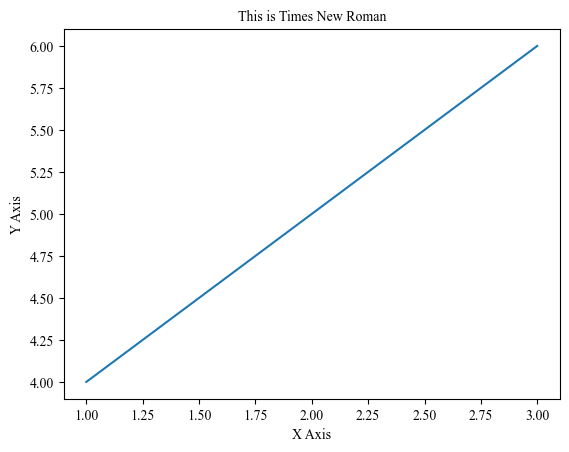

In [87]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 1. 加载本地字体文件
font_path = "./times.ttf"
my_font_prop = fm.FontProperties(fname=font_path)

# 2. 手动添加这个字体到 matplotlib 的字体列表（确保优先使用它）
fm.fontManager.addfont(font_path)

# 3. 设置全局字体为该字体的名称（保证用的是你加载的本地字体）
plt.rcParams["font.family"] = my_font_prop.get_name()

# 4. 打印字体名称确认
print("当前使用字体:", my_font_prop.get_name())

# 5. 测试绘图
plt.plot([1, 2, 3], [4, 5, 6])
plt.title("This is Times New Roman", fontproperties=my_font_prop)
plt.xlabel("X Axis", fontproperties=my_font_prop)
plt.ylabel("Y Axis", fontproperties=my_font_prop)
plt.show()


Attention min: -20.75, max: 0.0


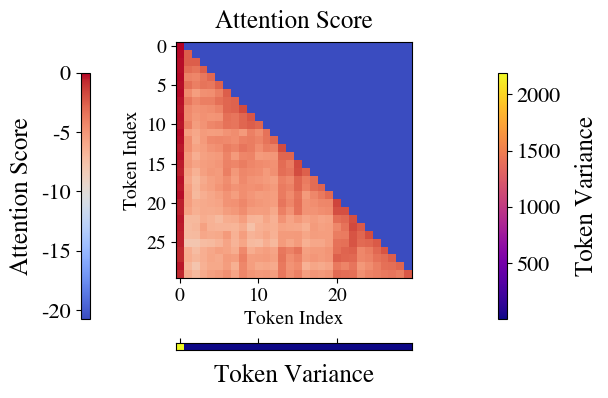

In [110]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.ticker as mticker

from matplotlib import font_manager as fm

# 加载字体文件
# 1. 加载本地字体文件
font_path = "./timr45w.ttf"
my_font_prop = fm.FontProperties(fname=font_path)

# 2. 手动添加这个字体到 matplotlib 的字体列表（确保优先使用它）
fm.fontManager.addfont(font_path)

# 3. 设置全局字体为该字体的名称（保证用的是你加载的本地字体）
plt.rcParams["font.family"] = my_font_prop.get_name()
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.family"] = "DejaVu Serif"


def visualize_multi_layers_single_row(
    attention_scores,
    hidden_states,
    layers,              # list/iterable of layer indices to plot
    head_idx,            # 如果你只想看同一个 head，可固定 head_idx
    seq_len,
    output_file=None,
    norm_type="log",     # "log", "minmax", 或 None
    cmap_attn="plasma",  # 注意力图的colormap
    cmap_var="viridis",  # 方差图的colormap
    annotate=False
):
    """
    在"只有一行"的布局下，横向排多个 Layer，每个 Layer 里再上下叠放:
      - 上: 注意力 (seq_len×seq_len)
      - 下: 方差   (1×seq_len)
    左右两侧各只放一个 colorbar：左边给所有注意力图，右边给所有方差图。

    最外层 1×(num_layers + 2) 网格结构:
    ┌──────────┬────────────────┬────────────────┬ ... ┬─────────────────┬───────────┐
    │ 左CB(col=0) │ Layer1(subgrid) │ Layer2(subgrid) │ ... │ LayerN(subgrid) │ 右CB(col=N+1)│
    └──────────┴────────────────┴────────────────┴-----┴─────────────────┴───────────┘

    其中每个 layer 的 subgrid 再是 2×1:
      - row=0: 注意力热力图(上)
      - row=1: 方差热力图(下)
    """

    num_layers = len(layers)

    #========== 1. 预先收集所有矩阵、计算全局 min/max ==========#
    all_attention_mats = []
    all_variance_mats  = []
    for layer_idx in layers:
        # ---- 注意力矩阵 ----
        # attn_mat = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()
        # print(attention_scores[0].shape)
        attn_tensor = attention_scores[layer_idx][0, :, :seq_len, :seq_len].cpu()  # (n_heads, seq, seq)
        attn_mat = attn_tensor.mean(dim=0)                                         # (seq, seq)

        if norm_type == "log":
            epsilon = 1e-9
            attn_mat = torch.log(attn_mat + epsilon)
        elif norm_type == "minmax":
            attn_mat = (attn_mat - attn_mat.min()) / (attn_mat.max() - attn_mat.min() + 1e-9)
        attn_mat = attn_mat.float().numpy()
        all_attention_mats.append(attn_mat)

        # ---- 方差矩阵(1×seq_len) ----
        var_mat = torch.var(hidden_states[layer_idx][:, :seq_len, :], dim=-1).squeeze(0).cpu().float().numpy()
        var_mat = np.expand_dims(var_mat, axis=0)  # 变成 (1, seq_len)
        all_variance_mats.append(var_mat)

    # (可选) 全局 min/max, 用于共享色表
    attn_min = min(m.min() for m in all_attention_mats)
    attn_max = max(m.max() for m in all_attention_mats)
    print(f"Attention min: {attn_min}, max: {attn_max}")
    var_min  = min(m.min() for m in all_variance_mats)
    var_max  = max(m.max() for m in all_variance_mats)

    attn_norm = mpl.colors.Normalize(vmin=attn_min, vmax=attn_max)
    var_norm  = mpl.colors.Normalize(vmin=var_min, vmax=var_max)

    #========== 2. 创建最外层 figure & gridspec (1 行 + num_layers+2 列) ==========#
    fig = plt.figure(figsize=(3.5 + 2*num_layers, 4))
    gs_main = fig.add_gridspec(
        nrows=1, ncols=num_layers+2,
        width_ratios=[0.05] + [2]*num_layers + [0.05],  # 左 colorbar, 中间每层, 右 colorbar
        wspace=0.0
    )

    # 左、右 colorbar Axes
    cax_left  = fig.add_subplot(gs_main[0, 0])
    cax_right = fig.add_subplot(gs_main[0, num_layers+1])

    #========== 3. 遍历每个 layer，在中间相应的列创建 2×1 subgridspec ==========#
    for i, layer_idx in enumerate(layers):
        # 这个列在 top-level gridspec 中是 col = i + 1
        subgrid = gs_main[0, i+1].subgridspec(nrows=3, ncols=1, height_ratios=[16, 0.0, 0.5], hspace=0.4)

        # -- 上: 注意力热力图 --
        ax_top = fig.add_subplot(subgrid[0, 0])
        attn_mat = all_attention_mats[i]
        im_top = ax_top.imshow(
            attn_mat,
            cmap=cmap_attn,  # 使用注意力的colormap
            norm=attn_norm,
            aspect="equal",
            interpolation="nearest"
        )
        # 标题
        ax_top.set_title(f"Attention Score", pad=10, fontsize=18)

        ax_top.set_xlabel("Token Index", fontsize=14)
        # 如果是第一个 layer，添加 y 轴标签
        if i == 0:
            ax_top.set_ylabel("Token Index", fontsize=14)
        # 保证上图是 NxN 正方形
        ax_top.set_box_aspect(1)

        # 是否在热力图内显示数值
        if annotate:
            s_len = attn_mat.shape[0]
            for r in range(s_len):
                for c in range(s_len):
                    ax_top.text(c, r, f"{attn_mat[r,c]:.2f}",
                                ha="center", va="center", fontsize=6)

        # 设置刻度标签大小
        ax_top.tick_params(labelsize=14)

        # -- 下: 方差热力图(1×seq_len) --
        ax_bottom = fig.add_subplot(subgrid[2, 0])
        var_mat = all_variance_mats[i]

        # 获取上图的位置信息
        pos_top = ax_top.get_position()

        im_bottom = ax_bottom.imshow(
            var_mat,
            cmap=cmap_var,  # 使用方差的colormap
            norm=var_norm,
            aspect="auto",
            interpolation="nearest"
        )

        # 调整底部图的位置，使其宽度与上图一致
        pos_bottom = ax_bottom.get_position()
        ax_bottom.set_position([pos_top.x0, pos_bottom.y0, pos_top.width, pos_bottom.height])

        ax_bottom.set_xlabel("Token Variance", fontsize=18, labelpad=10)
        ax_bottom.tick_params(axis='x', which='both', labelbottom=False)
        ax_bottom.xaxis.tick_top()
        ax_bottom.set_yticks([])  # 隐藏 y 轴

        # 如果是最后一个 layer，可以添加右侧 text（当前已注释）
        # if i == num_layers - 1:
        #     ax_top.text(1.14, 0.5, "Attention Score", transform=ax_top.transAxes, rotation=90, va="center", ha="center", fontsize=18)

    #========== 4. 整体只放两个 colorbar：左(注意力)、右(方差) ==========#
    # 注意力 colorbar (使用 plasma)
    sm_attn = mpl.cm.ScalarMappable(norm=attn_norm, cmap=cmap_attn)
    cb1 = fig.colorbar(sm_attn, cax=cax_left, orientation='vertical')
    cb1.ax.yaxis.set_ticks_position('left')
    cb1.ax.yaxis.set_label_position('left')
    cb1.set_label("Attention Score", fontsize=18, labelpad=5)
    # 设置刻度标签大小
    cb1.ax.tick_params(labelsize=16)

    # 方差 colorbar (使用 viridis)
    sm_var = mpl.cm.ScalarMappable(norm=var_norm, cmap=cmap_var)
    cb2 = fig.colorbar(sm_var, cax=cax_right, orientation='vertical')
    cb2.set_label("Token Variance", fontsize=18, labelpad=10)
    # 设置刻度标签大小
    cb2.ax.tick_params(labelsize=16)

    # ---------- 在这里插入"空白" ----------
    def add_axes_padding(ax,
                         pad_left=0.0, pad_right=0.0,
                         pad_top=0.0, pad_bottom=0.0):
        """
        给指定的 ax 在四个方向上各留一定比例的空白：
          pad_left   : 左边留原宽度 pad_left 倍的空白，并向右移同样的距离
          pad_right  : 右边留原宽度 pad_right 倍的空白，并缩小宽度
          pad_bottom : 底部留原高度 pad_bottom 倍的空白，并向上移同样的距离
          pad_top    : 顶部留原高度 pad_top 倍的空白，并缩小高度

        参数均为相对比例，例如 pad_left=0.1 意味着「左边留出原宽度的 10%」。
        """
        x0, y0, w, h = ax.get_position().bounds

        new_x0 = x0 + pad_left * w
        new_width = w * (1 - pad_left - pad_right)
        new_y0 = y0 + pad_bottom * h
        new_height = h * (1 - pad_top    - pad_bottom)

        ax.set_position([new_x0, new_y0, new_width, new_height])

    # 调整 colorbars 的位置
    add_axes_padding(cax_left,  pad_left=0.0, pad_right=0.1,
                                 pad_top=0.10,  pad_bottom=0.10)
    add_axes_padding(cax_right, pad_left=0.1, pad_right=0.0,
                                 pad_top=0.10,  pad_bottom=0.10)

    #========== 5. 保存或显示 ==========#
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()

# 调用函数
layers_to_plot = [18]
visualize_multi_layers_single_row(
    attention_scores=output["attentions"],
    hidden_states=output["hidden_states"],
    layers=layers_to_plot,
    head_idx=2,
    seq_len=30,
    norm_type="log",           # 可选: "log", "minmax", 或 None
    cmap_attn="coolwarm",        # 注意力图用 plasma
    cmap_var="plasma",        # 方差图用 viridis
    annotate=False,
    output_file="Figure 3.pdf"
)